In [2]:
############################################################################
### MAIN QUESTION: What is the best spot/area to stay in Madrid (Spain)? ###
############################################################################
      # 1.Where do people tend to give a higher location rating?
      # 2.Where are there more options to choose from?
      # 3.Are the best areas too expensive?

    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

%matplotlib inline

# List of Airbnb accomodations available in Madrid (Spain)
      # Downloaded from http://insideairbnb.com/get-the-data/ on 10/23/2022
df_listings = pd.read_csv('./listings.csv')

# Only keep the columns we'll need:
df = df_listings[['id', 'latitude', 'longitude', 'number_of_reviews', 'price', 'review_scores_location']]

# Drop rows with NaN values on the review_scores_location column
df = df.dropna(subset=['review_scores_location'])

# Remove the $ from the price column, so it can be treated as a float
df[df.columns[4:]] = df[df.columns[4:]].replace('[\$,]', '', regex=True).astype(float)

# Drop houses under a minimum number of reviews (as their scores might not be realistic)
min_number_of_reviews = 30
df_best_loc = df[df['number_of_reviews'] > min_number_of_reviews]



# Define some points for geographical reference 
geo_ref = {'text':      ["Goya", "Atocha", "Pl. de España", "N. Ministerios", "Puerta del Sol", "Airport MAD"],
           'longitude': [-3.676,   -3.692,         -3.712,           -3.692,       -3.704,             -3.595],
           'latitude':  [40.425,   40.409,         40.423,           40.446,       40.417,             40.496]}

margin = 0.003 # Between the icons and the text

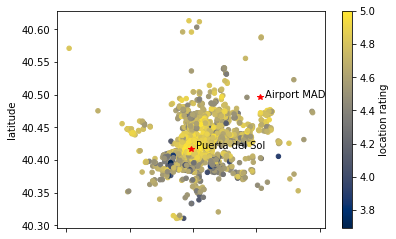

In [3]:
### Let's take a look at the data

# Make a scatter plot according to location rating
df_plot = pd.DataFrame({'longitude': df_best_loc['longitude'], 'latitude': df_best_loc['latitude'], 'location rating': df_best_loc['review_scores_location']})
ax = df_plot.plot(kind='scatter', x='longitude', y='latitude', c='location rating', colormap='cividis')

# Plot some geographical references
for x in range(4,6):
    ax.plot(geo_ref['longitude'][x], geo_ref['latitude'][x], "*r")
    ax.annotate(geo_ref['text'][x], (geo_ref['longitude'][x]+3*margin, geo_ref['latitude'][x]))


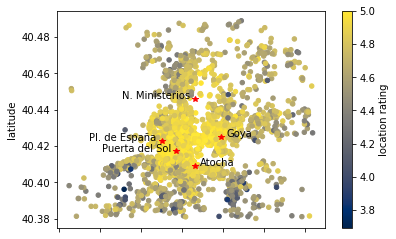

In [4]:
### Zoom in for a better visualization
df_zoom = df_best_loc
df_zoom = df_zoom[(df_zoom['latitude'] > 40.38) & (df_zoom['latitude'] < 40.49)]
df_zoom = df_zoom[(df_zoom['longitude'] > -3.77) & (df_zoom['longitude'] < -3.62)]

# Make a scatter plot according to location rating
df_plot = pd.DataFrame({'longitude': df_zoom['longitude'], 'latitude': df_zoom['latitude'], 'location rating': df_zoom['review_scores_location']})
ax = df_plot.plot(kind='scatter', x='longitude', y='latitude', c='location rating', colormap='cividis')

# Plot some geographical references
for x in range(2):
    ax.plot(geo_ref['longitude'][x], geo_ref['latitude'][x], "*r")
    ax.annotate(geo_ref['text'][x], (geo_ref['longitude'][x]+margin, geo_ref['latitude'][x]))
for x in range(2,5):
    ax.plot(geo_ref['longitude'][x], geo_ref['latitude'][x], "*r")
    ax.annotate(geo_ref['text'][x], (geo_ref['longitude'][x]-15*margin, geo_ref['latitude'][x]))

In [7]:
### We'll go over the map and create a grid with average values for each small region (whose size we'll define below). 

# Define the step (approx. 1 km in both cases)
step_long = 0.012  
step_lat = 0.009  

#Define the limits of the area we will go over
min_long = min(df_zoom['longitude'])
max_long = max(df_zoom['longitude'])
min_lat  = min(df_zoom['latitude'])
max_lat  = max(df_zoom['latitude'])

# Find the amount of longitude and latitude subdivisions according to the step
long_steps = math.ceil((max_long - min_long)/step_long)
lat_steps = math.ceil((max_lat - min_lat)/step_lat)

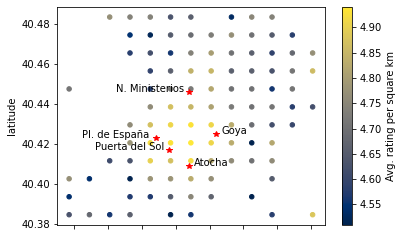

In [8]:
################################################################
### 1.Where do people tend to give a higher location rating? ###
################################################################

# Initialize the data frame where we'll store the results
grid_scores = pd.DataFrame([[min_long-step_long, min_lat-step_lat, float('nan')]],
                                  columns=['longitude', 'latitude', 'rating'])

# Go over the grid, calculate the average location rating for each region and add a row to the data frame
for x in range(long_steps):
    subset = df_zoom[(df_zoom['longitude'] > min_long + (x)*step_long) & (df_zoom['longitude'] < min_long + (x+1)*step_long)]
    for y in range(lat_steps): 
            aux = subset [(subset['latitude']   > min_lat + (y)*step_lat)  & (subset['latitude']   < min_lat + (y+1)*step_lat)]
            avg_loc_rating = round((aux['review_scores_location']).mean(), 2)
            new_row = pd.DataFrame([[min_long+(x)*step_long, min_lat+(y)*step_lat, avg_loc_rating]],
                                  columns=['longitude', 'latitude', 'rating'])
            grid_scores = pd.concat([grid_scores, new_row], ignore_index=True)

# Remove the row used to initialize the data frame 
grid_scores = grid_scores.dropna() 

# Only display results over a specific value
minimum_score = 4.5  
grid_scores = grid_scores[grid_scores['rating'] > minimum_score]

# Make a scatter plot 
df_plot = pd.DataFrame({'longitude': grid_scores['longitude']+step_long/2, 'latitude': grid_scores['latitude']+step_lat/2, 'Avg. rating per square km': grid_scores['rating']})
ax = df_plot.plot(kind='scatter', x='longitude', y='latitude', c='Avg. rating per square km', colormap='cividis')

# Plot some geographical references
for x in range(2):
    ax.plot(geo_ref['longitude'][x], geo_ref['latitude'][x], "*r")
    ax.annotate(geo_ref['text'][x], (geo_ref['longitude'][x]+margin, geo_ref['latitude'][x]))
for x in range(2,5):
    ax.plot(geo_ref['longitude'][x], geo_ref['latitude'][x], "*r")
    ax.annotate(geo_ref['text'][x], (geo_ref['longitude'][x]-14.5*margin, geo_ref['latitude'][x]))

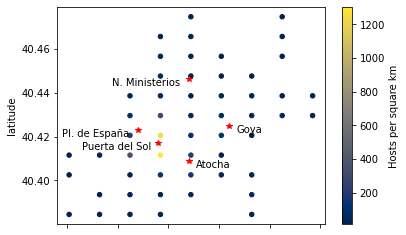

In [9]:
######################################################
### 2.Where are there more options to choose from? ###
######################################################

# Initialize the data frame where we'll store the results
grid_density = pd.DataFrame([[min_long-step_long, min_lat-step_lat, float('nan')]],
                                  columns=['longitude', 'latitude', 'density'])

# Go over the grid, calculate the amount of accomodations per region
for x in range(long_steps):
    subset = df_zoom[(df_zoom['longitude'] > min_long + (x)*step_long) & (df_zoom['longitude'] < min_long + (x+1)*step_long)]
    for y in range(lat_steps): 
            aux = subset [(subset['latitude']   > min_lat + (y)*step_lat)  & (subset['latitude']   < min_lat + (y+1)*step_lat)]
            amount = aux.shape[0]
            new_row = pd.DataFrame([[min_long+(x)*step_long, min_lat+(y)*step_lat, amount]],
                                  columns=['longitude', 'latitude', 'density'])
            grid_density = pd.concat([grid_density, new_row], ignore_index=True)

# Remove the row used to initialize the data frame 
grid_density = grid_density.dropna()

# Only display results over a specific value
grid_density = grid_density[grid_density['density'] > 10]

# Make a scatter plot 
df_plot = pd.DataFrame({'longitude': grid_density['longitude']+step_long/2, 'latitude': grid_density['latitude']+step_lat/2, 'Hosts per square km': grid_density['density']})
ax = df_plot.plot(kind='scatter', x='longitude', y='latitude', c='Hosts per square km', colormap='cividis')

# Plot some geographical references
for x in range(2):
    ax.plot(geo_ref['longitude'][x], geo_ref['latitude'][x], "*r")
    ax.annotate(geo_ref['text'][x], (geo_ref['longitude'][x]+margin, geo_ref['latitude'][x]-margin))
for x in range(2,5):
    ax.plot(geo_ref['longitude'][x], geo_ref['latitude'][x], "*r")
    ax.annotate(geo_ref['text'][x], (geo_ref['longitude'][x]-10*margin, geo_ref['latitude'][x]-margin))


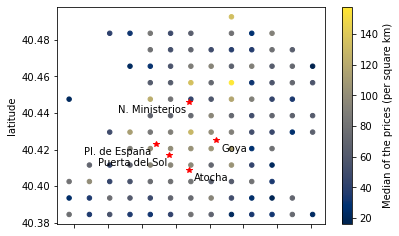

In [13]:
###########################################
### 3.Are the best areas too expensive? ###
###########################################

# Initialize the data frame where we'll store the results
grid_price = pd.DataFrame([[min_long-step_long, min_lat-step_lat, float('nan')]],
                                  columns=['longitude', 'latitude', 'price'])

# Go over the grid, calculate the MEDIAN of the price in each region
for x in range(long_steps):
    subset = df_zoom[(df_zoom['longitude'] > min_long + (x)*step_long) & (df_zoom['longitude'] < min_long + (x+1)*step_long)]
    for y in range(lat_steps): 
            aux = subset [(subset['latitude']   > min_lat + (y)*step_lat)  & (subset['latitude']   < min_lat + (y+1)*step_lat)]
            avg_price = round((aux['price']).median(), 2)
            new_row = pd.DataFrame([[min_long+(x)*step_long, min_lat+(y)*step_lat, avg_price]],
                                  columns=['longitude', 'latitude', 'price'])
            grid_price = pd.concat([grid_price, new_row], ignore_index=True)

# Remove the row used to initialize the data frame   
grid_price = grid_price.dropna()

# Remove outliers for a better visualization
grid_price = grid_price[grid_price['price']<400]

# Make a scatter plot according to location rating
df_plot = pd.DataFrame({'longitude': grid_price['longitude']+step_long/2, 'latitude': grid_price['latitude']+step_lat/2, 'Median of the prices (per square km)': grid_price['price']})
ax = df_plot.plot(kind='scatter', x='longitude', y='latitude', c='Median of the prices (per square km)', colormap='cividis')

# Plot some geographical references
for x in range(2):
    ax.plot(geo_ref['longitude'][x], geo_ref['latitude'][x], "*r")
    ax.annotate(geo_ref['text'][x], (geo_ref['longitude'][x]+margin, geo_ref['latitude'][x]-2*margin))
for x in range(2,5):
    ax.plot(geo_ref['longitude'][x], geo_ref['latitude'][x], "*r")
    ax.annotate(geo_ref['text'][x], (geo_ref['longitude'][x]-14*margin, geo_ref['latitude'][x]-2*margin))